In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
%load_ext autoreload
%autoreload 2

from settings import *
from glove import *
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from textblob import TextBlob
from tweets_ops import *
from url_helpers import analyze_url
from matching import *
from textstat.textstat import textstat
import urllib, bs4

pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter("ignore", category=UserWarning)

figures = conf['aux_dir']+'figure-eight/'

In [2]:
df6 = pd.read_csv(cache_dir+'article_details_v6.tsv', sep='\t')
df7 = pd.read_csv(cache_dir+'article_details_v7.tsv', sep='\t').fillna(0).drop('Alexa Rank', axis=1)
df7['Author Signature'] = df6['authors'].apply(lambda x: len(eval(x)) != 0)


In [3]:
df_crispr = pd.read_csv(cache_dir+'crispr.tsv', sep='\t').merge(df7, left_on='article', right_on='url')
dfD = pd.read_csv(figures+'crispr-Dimitra.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert1'}).sort_values(by='article')
dfJ = pd.read_csv(figures+'crispr-Jose.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert2'}).sort_values(by='article').drop('article', axis=1)
df_exp_crispr = pd.concat([dfD,dfJ], axis=1)[['article', 'expert1', 'expert2']]
df_exp_crispr.article = df_exp_crispr.article.apply(lambda x: x.replace('https://', 'http://'))
df_exp_crispr['expert'] = (df_exp_crispr['expert1'] + df_exp_crispr['expert2'])/2
df_crispr = df_crispr.merge(df_exp_crispr[['article', 'expert']])

df_atc = pd.read_csv(cache_dir+'alc_tob_caf.tsv', sep='\t').merge(df7, left_on='article', right_on='url')
dfAn = pd.read_csv(figures+'tobacco-Andreu.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert1'}).sort_values(by='article')
dfAi = pd.read_csv(figures+'tobacco-Aina.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert2'}).sort_values(by='article').drop('article', axis=1)
df_exp_atc = pd.concat([dfAn,dfAi], axis=1)[['article', 'expert1', 'expert2']]
df_exp_atc.article = df_exp_atc.article.apply(lambda x: x.replace('https://', 'http://'))
df_exp_atc['expert'] = (df_exp_atc['expert1'] + df_exp_atc['expert2'])/2
df_atc = df_atc.merge(df_exp_atc[['article', 'expert']])

In [4]:
X_crispr = np.array(df_crispr.drop(['article', 'paper', 'title', 'url', 'expert'], axis=1).values, dtype=np.float32)
y_crispr = df_crispr['expert'].values
y_crispr = y_crispr.round().astype(int)

X_atc = np.array(df_atc.drop(['article','paper1', 'title1', 'paper2', 'title2', 'paper3', 'title3', 'title', 'url', 'expert'], axis=1).values, dtype=np.float32)
y_atc = df_atc['expert'].values
y_atc = y_atc.round().astype(int)

In [5]:
df7['url'] = df7['url'].apply(lambda x: analyze_url(x)[0])
df7 = df7.merge(pd.read_csv(cache_dir+'acsh.tsv', sep='\t'), left_on='url', right_on='outlet')

In [6]:
df8=df7
#df8 = df7[df7['url'].isin(['nytimes.com', 'dailymail.co.uk'])] #theatlantic.com, dailymail.co.uk, nytimes.com

In [7]:
X_train = np.array(df8.drop(['outlet', 'url', 'rate'], axis=1).values, dtype=np.float32)
y_train = df8['rate'].values

# n_est = 250
# m_dep = 200

# classifier = RandomForestClassifier(n_estimators=n_est, max_depth=m_dep, n_jobs=-1, random_state=42)

# classifier.fit(X_train, y_train)
# imp = classifier.feature_importances_

# d = {c:r for c, r in zip(df7.drop(['outlet', 'url', 'rate'], axis=1).columns, imp)}
#pd.DataFrame(sorted(d.items(), key=lambda kv: kv[1], reverse=True))[0][:6]

from sklearn.feature_selection import f_classif
_, result = f_classif(X_train,y_train)

d = {c:r for c, r in zip(df7.drop(['outlet', 'url', 'rate'], axis=1).columns, result)}
df = pd.DataFrame(sorted(d.items(), key=lambda kv: kv[1]))

df[0] = df.apply(lambda x: x[0]+'***' if float(x[1])<.005 else x[0]+'**' if float(x[1])<.01 else x[0]+'*' if float(x[1])<.05 else x[0], axis=1)

df[:4]


# classifier.fit(X_train, y_train)
# print(n_est, m_dep, classifier.score(X_atc, y_atc))
# df_atc['scilens'] = classifier.predict(X_atc)

#classifier.fit(X_train, y_train)
#print(n_est, m_dep, classifier.score(X_crispr, y_crispr))    
# df_crispr['scilens'] = classifier.predict(X_crispr)

#df_atc[['article', 'scilens']].to_csv(cache_dir+'scilens_atc.tsv', sep='\t', index=None)

,0,1
0,Author Signature***,2.886974e-09
1,Article Word Count***,8.036483e-07
2,#Scientific Mentions***,2.083265e-03
3,Readability***,4.042391e-03


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


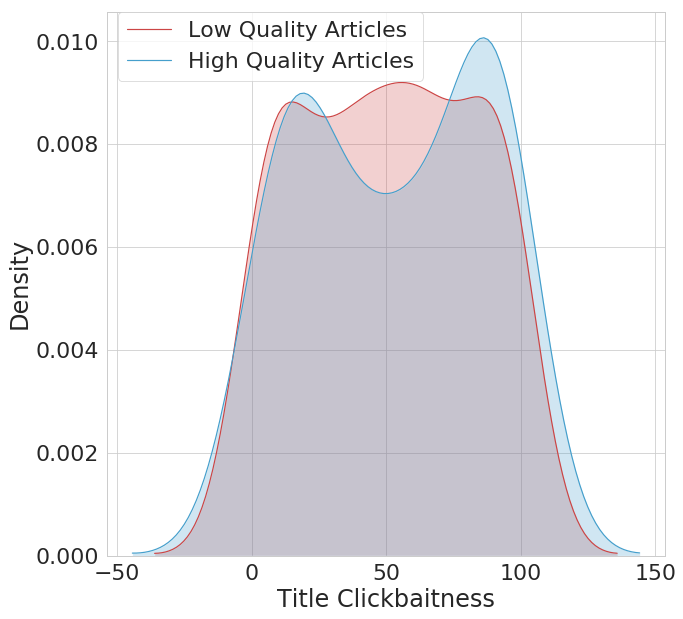

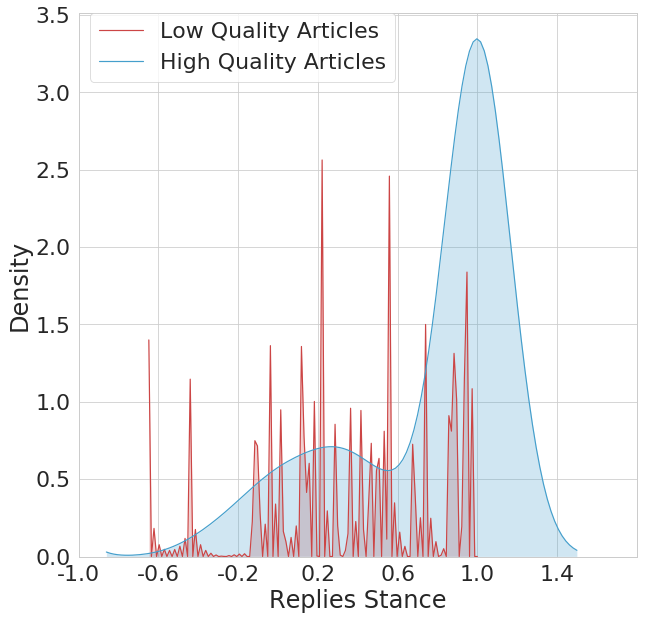

In [9]:
for ind, name in zip(['Title Clickbaitness', 'Replies Stance'], ['clickbait_distro', 'stance_distro']):
    sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=2.5)
    fig, ax = plt.subplots(figsize=(10,10))
    for r, q, c in zip([-1, 1], ['Low', 'High'], ['#CC4545', '#459FCC']):
        ax = sns.kdeplot(df8[df8['rate']==r][ind], label=q+' Quality Articles', color=c, shade= True, ax=ax)

    plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(0, 1.02))
    plt.xlabel(ind)
    plt.ylabel('Density')
    
    if name == 'stance_distro':
        plt.xlim(1, -0.4)
        loc, _ = plt.xticks()
        loc = np.delete(loc, -0.4)
        plt.xticks(loc, [round(1- 2*l,2) for l in loc])
    fig.savefig(figures+'plots/'+name+'.pdf', bbox_inches='tight')
